# Project 1 -  Text Classification Task

## 1 - Data Provenance and Characteristics

The dataset we will be working with consists of publications sourced from Reddit and Google, authored by individuals from England, Australia, and India. 

The Reddit-sourced data is divided as follows:

- Reddit (England): Training data and test data
- Reddit (Australia): Training data and test data
- Reddit (India): Training data and test data

Similarly, an equivalent division applies to the Google-sourced data:

- Google (England): Training data and test data
- Google (Australia): Training data and test data
- Google (India): Training data and test data

All datasets share the same attributes: `id`, a unique identifier for each entry, `text`, the content of the publication, and `sentiment_label`, the target variable for our analysis. The `sentiment_label` is binary, where `0` indicates a negative sentiment and `1` indicates a positive sentiment.

## 2 - Exploratory Data Analysis

### 2.1 - Initial Setup

We begin by reading all 12 datasets. Since the distinction between training and test data is not relevant for our analysis, we first merge them, reducing the total to 6 datasets.

To further facilitate analysis, we also create 3 additional datasets, grouping the data by country of origin. In this step, we combine Reddit and Google data while keeping separate datasets for England, Australia, and India Moreover, we also create 3 datasets, grouping the data by their source, this is Reddit or Google.

In the end, we also created a global dataset, that is, with all the data we have available.

In addition, we remove the `id` attribute at the beginning of our process. This decision was made to prevent inconsistencies, as some publications shared the same `id` across different datasets. Keeping this attribute could lead to ambiguity in the data.

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import spacy
import os

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# nlp = spacy.load("en_core_web_sm")

In [32]:
# read Reddit-sourced data 
reddit_uk_train = pd.read_json("data/reddit-uk-train.jsonl", lines=True).drop("id", axis=1)
reddit_in_train = pd.read_json("data/reddit-in-train.jsonl", lines=True).drop("id", axis=1)
reddit_au_train = pd.read_json("data/reddit-au-train.jsonl", lines=True).drop("id", axis=1)
reddit_uk_valid = pd.read_json("data/reddit-uk-valid.jsonl", lines=True).drop("id", axis=1)
reddit_in_valid = pd.read_json("data/reddit-in-valid.jsonl", lines=True).drop("id", axis=1)
reddit_au_valid = pd.read_json("data/reddit-au-valid.jsonl", lines=True).drop("id", axis=1)

# read Google-sourced data 
google_uk_train = pd.read_json("data/google-uk-train.jsonl", lines=True).drop("id", axis=1)
google_in_train = pd.read_json("data/google-in-train.jsonl", lines=True).drop("id", axis=1)
google_au_train = pd.read_json("data/google-au-train.jsonl", lines=True).drop("id", axis=1)
google_uk_valid = pd.read_json("data/google-uk-valid.jsonl", lines=True).drop("id", axis=1)
google_in_valid = pd.read_json("data/google-in-valid.jsonl", lines=True).drop("id", axis=1)
google_au_valid = pd.read_json("data/google-au-valid.jsonl", lines=True).drop("id", axis=1)

# merge Reddit-sourced data by country
reddit_uk_union = pd.concat([reddit_uk_train, reddit_uk_valid], ignore_index=True)
reddit_au_union = pd.concat([reddit_au_train, reddit_au_valid], ignore_index=True)
reddit_in_union = pd.concat([reddit_in_train, reddit_in_valid], ignore_index=True)

# merge Google-sourced data by country
google_uk_union = pd.concat([google_uk_train, google_uk_valid], ignore_index=True)
google_au_union = pd.concat([google_au_train, google_au_valid], ignore_index=True)
google_in_union = pd.concat([google_in_train, google_in_valid], ignore_index=True)

# merge data by country
uk_union = pd.concat([reddit_uk_union, google_uk_union], ignore_index=True)
au_union = pd.concat([reddit_au_union, google_au_union], ignore_index=True)
in_union = pd.concat([reddit_in_union, google_in_union], ignore_index=True)

# merge data by source
reddit_union = pd.concat([reddit_uk_union, reddit_au_union, reddit_in_union], ignore_index=True)
google_union = pd.concat([google_uk_union, google_au_union, google_in_union], ignore_index=True)

# merge all data
global_union = pd.concat([reddit_union, google_union])

### 2.2 - Class Distribution by Source

We begin by comparing the number of entries from Reddit and Google. Our analysis shows that both sources contain approximately the same number of entries.

Next, we analyzed the distribution of the sentiment class in both sources. This analysis reveals that Reddit data is predominantly negative, while Google data is mostly positive.

In [33]:
print("From Reddit there are " + str(len(reddit_union)))
print("From Google there are " + str(len(google_union)))

From Reddit there are 5064
From Google there are 5014


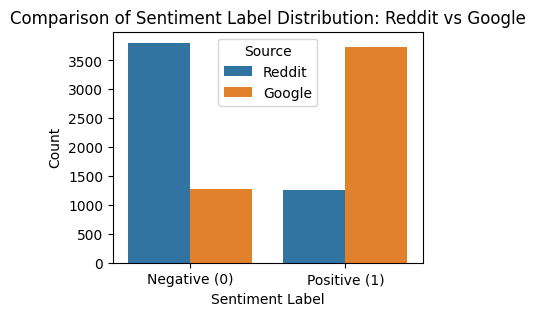

In [34]:
# count distribuition of the target class by source
reddit_counts = reddit_union["sentiment_label"].value_counts().reset_index()
google_counts = google_union["sentiment_label"].value_counts().reset_index()

# create dataframe
reddit_counts.columns = ["sentiment_label", "Reddit"]
google_counts.columns = ["sentiment_label", "Google"]
df = pd.merge(reddit_counts, google_counts, on="sentiment_label", how="outer")
df_melted = df.melt(id_vars="sentiment_label", var_name="Source", value_name="Count")

# create graph
plt.figure(figsize=(4,3))
sns.barplot(data=df_melted, x="sentiment_label", y="Count", hue="Source", palette=["#1f77b4", "#ff7f0e"])
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.title("Comparison of Sentiment Label Distribution: Reddit vs Google")
plt.xticks(ticks=[0, 1], labels=["Negative (0)", "Positive (1)"])
plt.legend(title="Source")
plt.show()

### 2.2 - Class Distribution by Country

Similarly to the source analysis, we also examined the distribution of the data across countries, as well as the balance of the target class distribution.

As shown below, the datasets have roughly the same number of entries, and the target class is approximately evenly distributed.

In [35]:
print("From UK there are " + str(len(uk_union)))
print("From AU there are " + str(len(au_union)))
print("From IN there are " + str(len(in_union)))

From UK there are 3210
From AU there are 3080
From IN there are 3788


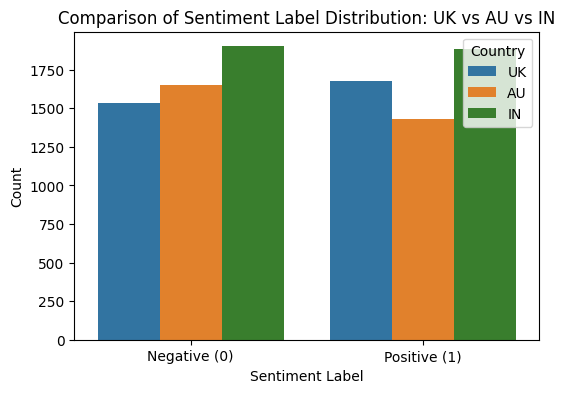

In [36]:
# count distribuition of the target class by country
uk_counts = uk_union["sentiment_label"].value_counts().reset_index()
au_counts = au_union["sentiment_label"].value_counts().reset_index()
in_counts = in_union["sentiment_label"].value_counts().reset_index()

# create dataframe
uk_counts.columns = ["sentiment_label", "UK"]
au_counts.columns = ["sentiment_label", "AU"]
in_counts.columns = ["sentiment_label", "IN"]
df_counts = pd.merge(uk_counts, au_counts, on="sentiment_label", how="outer")
df_counts = pd.merge(df_counts, in_counts, on="sentiment_label", how="outer")
df_melted = df_counts.melt(id_vars="sentiment_label", var_name="Country", value_name="Count")

# create graph
plt.figure(figsize=(6,4))
sns.barplot(data=df_melted, x="sentiment_label", y="Count", hue="Country", palette=["#1f77b4", "#ff7f0e", "#2f8c1f"])
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.title("Comparison of Sentiment Label Distribution: UK vs AU vs IN")
plt.xticks(ticks=[0, 1], labels=["Negative (0)", "Positive (1)"])
plt.legend(title="Country")
plt.show()

### 2.3 - Word Distribution by Source

Next, we analyze the distribution of words by source, focusing on the top 10 words. As shown, despite the words appearing in different positions across the sources, there are 3 common words. This low number may be due to the topic of the posts, which can be very different between platforms.

In [37]:
# function to calculate and plot TF-IDF
def plot_tfidf(dataset, title):
    
    # get text column
    texts = dataset["text"]  
    
    # start TfidfVectorizer
    vectorizer = TfidfVectorizer(stop_words='english', max_features=20)
    tfidf_matrix = vectorizer.fit_transform(texts)   
    terms = vectorizer.get_feature_names_out()   
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)   
    sum_tfidf = tfidf_df.sum(axis=0)   
    sorted_tfidf = sum_tfidf.sort_values(ascending=False)
    
    # plot graph
    plt.figure(figsize=(6, 3))
    sorted_tfidf.head(10).plot(kind='bar')
    plt.title(title)
    plt.ylabel('TF-IDF Score')
    plt.xlabel('Words')
    plt.xticks(rotation=45)
    plt.show()
    
    return sorted_tfidf.head(10).index.tolist()

def plot_wordcolud(dataset):
    wordcloud = WordCloud().generate(" ".join(dataset["text"].dropna().astype(str)))
    plt.figure(figsize=(6, 3))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

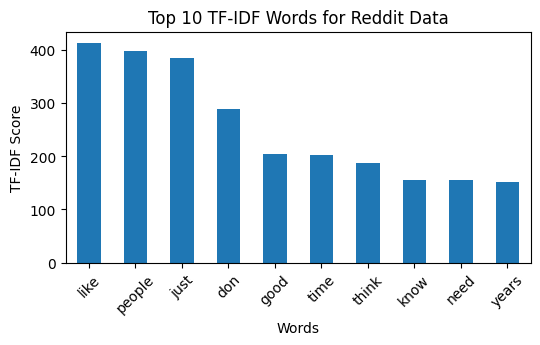

In [38]:
reddit_top = plot_tfidf(reddit_union, 'Top 10 TF-IDF Words for Reddit Data')

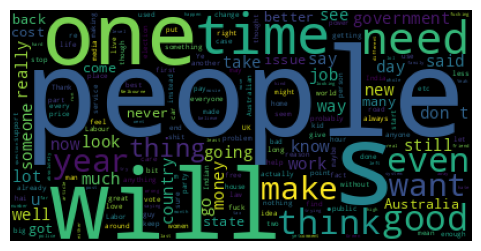

In [39]:
plot_wordcolud(reddit_union)

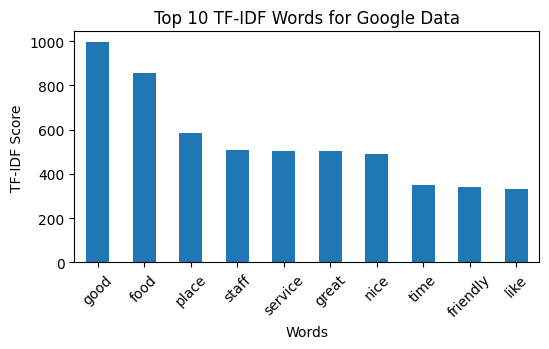

In [40]:
google_top = plot_tfidf(google_union, 'Top 10 TF-IDF Words for Google Data')

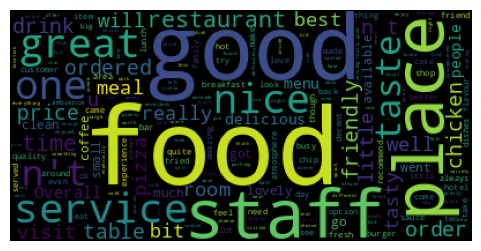

In [41]:
plot_wordcolud(google_union)

In [42]:
comumn_top = list(set(reddit_top) & set(google_top))

print("There are " + str(len(comumn_top)) + " comumn words.")
print("They are : " + str(comumn_top))

There are 3 comumn words.
They are : ['good', 'like', 'time']


### 2.3 - Word Distribution by Country

We also analyzed the distribution of words by country. As shown, the vocabulary does not seem to vary significantly across countries, as the number of common words between two datasets ranges from 7 to 8 out of 10.

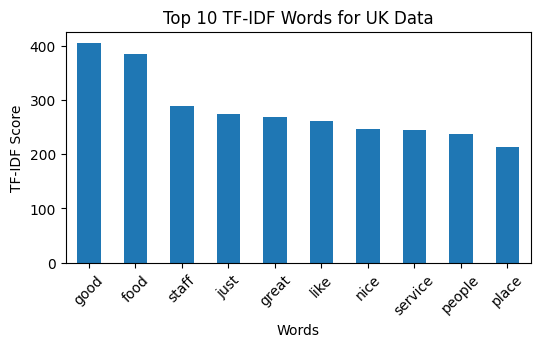

In [43]:
uk_top = plot_tfidf(uk_union, 'Top 10 TF-IDF Words for UK Data')

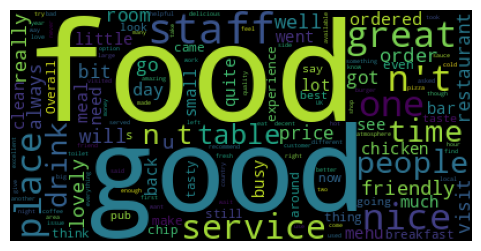

In [44]:
plot_wordcolud(uk_union)

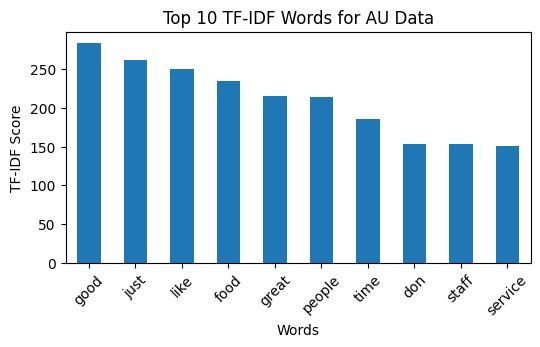

In [45]:
au_top = plot_tfidf(au_union, 'Top 10 TF-IDF Words for AU Data')

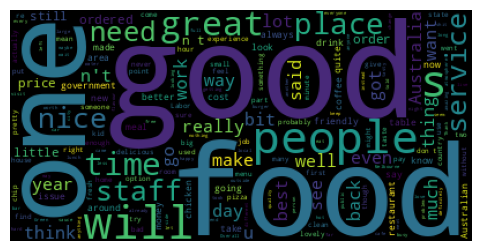

In [46]:
plot_wordcolud(au_union)

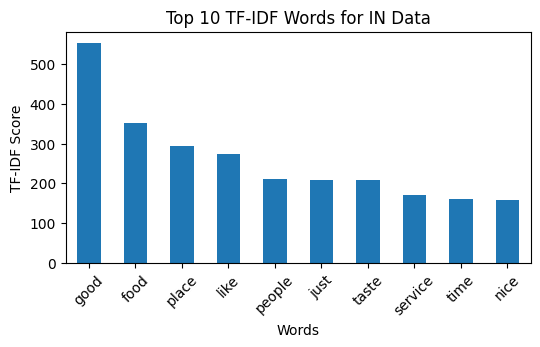

In [47]:
in_top = plot_tfidf(in_union, 'Top 10 TF-IDF Words for IN Data')

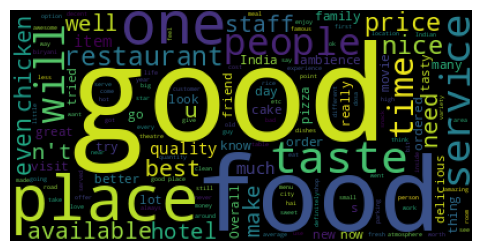

In [48]:
plot_wordcolud(in_union)

In [49]:
comumn_uk_au_top = list(set(uk_top) & set(au_top))
comumn_au_in_top = list(set(au_top) & set(in_top))
comumn_in_uk_top = list(set(in_top) & set(uk_top))

print("UK and AU")
print("There are " + str(len(comumn_uk_au_top)) + " comumn words.")
print("They are : " + str(comumn_uk_au_top))

print("\nAU and IN")
print("There are " + str(len(comumn_au_in_top)) + " comumn words.")
print("They are : " + str(comumn_au_in_top))

print("\nIN and UK")
print("There are " + str(len(comumn_in_uk_top)) + " comumn words.")
print("They are : " + str(comumn_in_uk_top))

UK and AU
There are 8 comumn words.
They are : ['just', 'like', 'staff', 'service', 'great', 'good', 'food', 'people']

AU and IN
There are 7 comumn words.
They are : ['like', 'just', 'time', 'service', 'good', 'food', 'people']

IN and UK
There are 8 comumn words.
They are : ['nice', 'place', 'just', 'like', 'service', 'good', 'food', 'people']


### 2.4 - Word Distribuition by Class

We also analyzed the word distribution by class, separating the publications based on their connotation, positive or negative.

In positive publications, words like "good," "nice," and "great" stand out, which aligns with their typical use in expressing positive sentiments.

Conversely, in negative publications, these words are noticeably less common. While "good" still appears frequently, it is not as prominent as in positive posts. Additionally, the word "n't" is highly recurrent, highlighting its role in negation and negative sentiment formation.

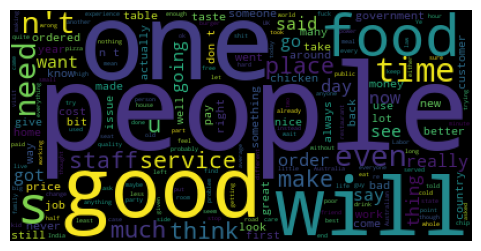

In [50]:
plot_wordcolud(global_union[global_union["sentiment_label"] == 0])

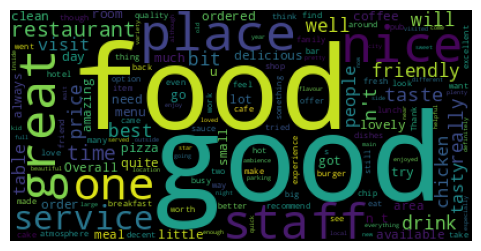

In [51]:
plot_wordcolud(global_union[global_union["sentiment_label"] == 1])

## 3 - Data Pre-Processing
In the data preprocessing step, we remove all characters that are not alphabetical or whitespace. Additionally, we convert the text to lowercase and eliminate consecutive spaces. After cleaning the text, we perform tokenization and stemming. Finally, we remove words from the stopwords list, except for those with negation, as they are crucial for our classification task

In [52]:
tokenizer = nltk.word_tokenize
stemmer = nltk.PorterStemmer()
stop_words = set(nltk.corpus.stopwords.words('english'))

stop_words.remove("no")
stop_words.remove("not")
stop_words.remove("nor")
stop_words.remove("t")

# remove words related with negation
stop_words_remove = {"no", "not", "nor", "t"}
stop_words.difference_update(stop_words_remove)

def text_pre_processing(dataset):
    dataset['text'] = dataset["text"].apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x).strip())
    dataset["text"] = dataset["text"].apply(str.lower)
    dataset["text"] = dataset["text"].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
    dataset['text'] = dataset['text'].apply(tokenizer)
    dataset['text'] = dataset['text'].apply(lambda x: [stemmer.stem(w) for w in x])
    dataset['text'] = dataset['text'].apply(lambda x: [word for word in x if word not in stop_words])
    dataset['text'] = [" ".join(text) for text in dataset["text"]]
    
def metrics(y_test, y_pred):
    [[tp, fp], [tn, fn]] = (confusion_matrix(y_test, y_pred))
    print("         True  False")
    print("positive  " + str(tp) + "   " + str(fp))
    print("negative  " + str(tn) + "   " + str(fn))
    print(f"\nAccuracy {accuracy_score(y_test, y_pred):.2f} Precision {precision_score(y_test, y_pred):.2f} Recall {recall_score(y_test, y_pred):.2f} F1 Score {f1_score(y_test, y_pred):.2f}")

text_pre_processing(uk_union)
text_pre_processing(au_union)
text_pre_processing(in_union)
text_pre_processing(global_union)

print(uk_union['text'].iloc[0])
print(len(uk_union['text'].iloc[0]))

['instead', 'make', 'save', 'continu', 'spend', 'money', 't', 'ye', 'sound', 'veri', 'respons', 'mayb', 'govern', 'continu', 'spend', 'whole', 'countri', 'would', 'financi', 'mess', 'birmingham']
['instead', 'make', 'saving', 'continue', 'spend', 'money', 't', 'yes', 'sound', 'responsible', 'maybe', 'government', 'continue', 'spend', 'whole', 'country', 'would', 'financial', 'mess', 'birmingham']
21
20


In [53]:
folder_path = "data_prepared"
os.makedirs(folder_path, exist_ok=True)

uk_union.to_csv(os.path.join(folder_path, "uk_union.csv"), index=False)
au_union.to_csv(os.path.join(folder_path, "au_union.csv"), index=False)
in_union.to_csv(os.path.join(folder_path, "in_union.csv"), index=False)

global_union.to_csv(os.path.join(folder_path, "global_union.csv"), index=False)

### 3.1 - Features from Bag-of-Words

The simplest way to accomplish this is by creating a Bag-of-Words model, which ignores the sequence of words. To do this, we convert a collection of text documents into a matrix of token counts. We then use this data to classify the test set using a Multinomial Naive Bayes classifier.

In [54]:
vectorizer = CountVectorizer(stop_words=None)
corpus = global_union["text"].dropna().astype(str).tolist()

# split data in training and testing
X = vectorizer.fit_transform(corpus).toarray()
y = global_union['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# classify using Multinomial Naive Bayes
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred_nb = clf.predict(X_test)
print("Multinomial Naive Bayes\n")
metrics(y_test, y_pred_nb)

# classify using Logistic Regression
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred_log = clf.predict(X_test)
print("\nLogistic Regression\n")
metrics(y_test, y_pred_log)

In [55]:
vectorizer = TfidfVectorizer(stop_words=None)
corpus = global_union["text"].dropna().astype(str).tolist()

# split data in training and testing
X = vectorizer.fit_transform(corpus).toarray()
y = global_union['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# classify using Multinomial Naive Bayes
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred_nb = clf.predict(X_test)
print("Multinomial Naive Bayes\n")
metrics(y_test, y_pred_nb)

# classify using Logistic Regression
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred_log = clf.predict(X_test)
print("\nLogistic Regression\n")
metrics(y_test, y_pred_log)

Confusion Matrix :

         True  False
positive  780   227
negative  159   850


Accuracy   0.81
Precision  0.79
Recall     0.84
F1 Score   0.81


### 3.2 - VADER

Something about vader

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

y_pred = []
for rev in dataset['Review']:
    y_pred.append(1 if analyzer.polarity_scores(rev)['compound'] > 0 else 0)

print(confusion_matrix(y, y_pred))
print('Accuracy: ', accuracy_score(y, y_pred))
print('Precision: ', precision_score(y, y_pred))
print('Recall: ', recall_score(y, y_pred))
print('F1: ', f1_score(y, y_pred))